/tmp/ipykernel_380320/3331772551.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


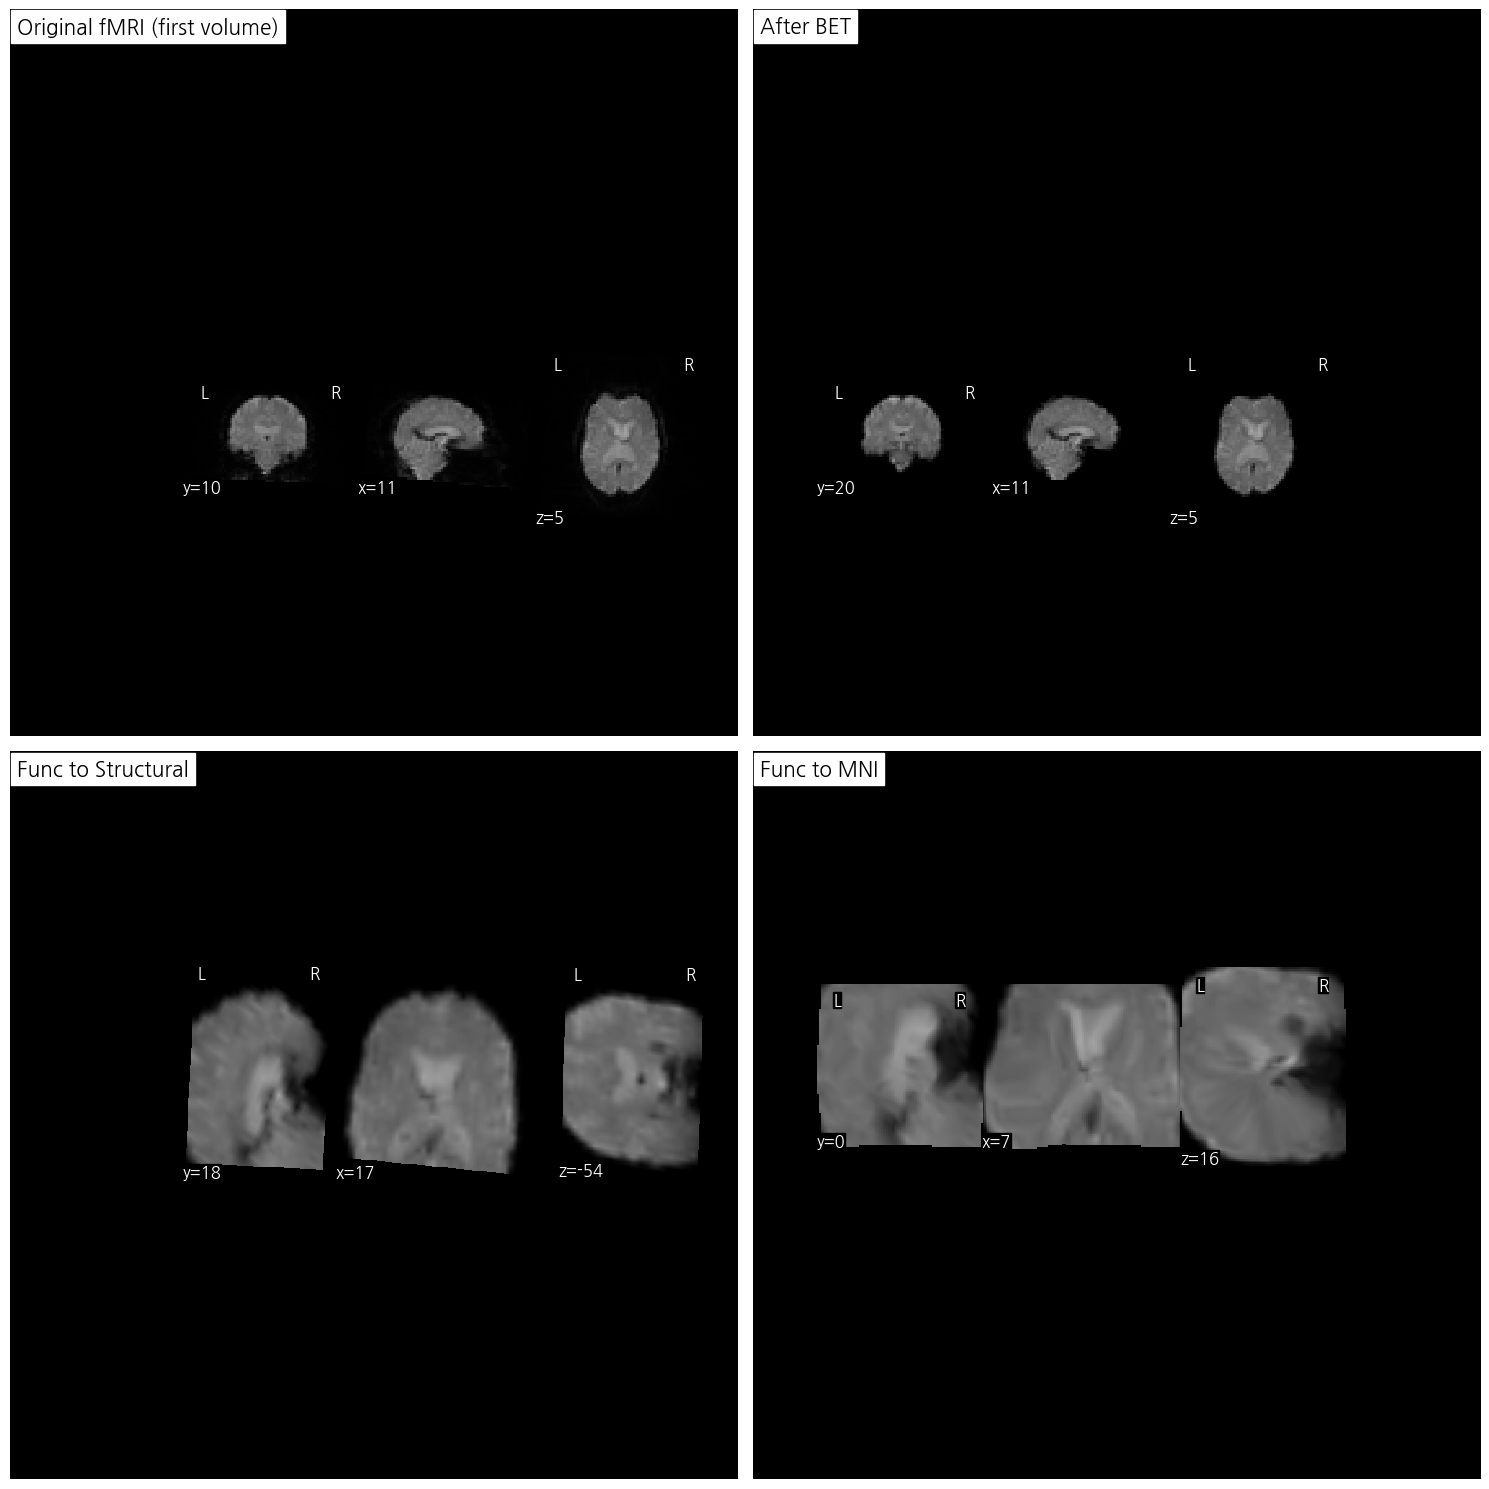

Preprocessing completed. Check the visualizations.


In [8]:
import os
import nibabel as nib
import numpy as np
from nipype.interfaces import fsl
from nilearn import plotting
import matplotlib.pyplot as plt

base_dir = "/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1"
subject_dir = "OAS30011_MR_d0055"
subject_id = "OAS30011"
session_id = "d0055"

func_file = os.path.join(base_dir, subject_dir, "func2", "NIFTI", f"sub-{subject_id}_ses-{session_id}_task-rest_run-02_bold.nii.gz")

struct_file = os.path.join(base_dir, subject_dir, "anat2", "NIFTI", f"sub-{subject_id}_ses-{session_id}_T1w.nii.gz")

mni_template = os.path.join(os.environ['FSLDIR'], 'data', 'standard', 'MNI152_T1_2mm_brain.nii.gz')

work_dir = os.path.join(base_dir, subject_dir, "fMRI_preprocessing")
os.makedirs(work_dir, exist_ok=True)


def visualize_results(original, bet, func_to_struct, func_to_mni):
    fig, axes = plt.subplots(4, 3, figsize=(20, 25))
    fig.suptitle("fMRI Preprocessing Results", fontsize=16)
    
    images = [original, bet, func_to_struct, func_to_mni]
    titles = ["Original fMRI (first volume)", "After BET", "Func to Structural", "Func to MNI"]
    
    for i, (img, title) in enumerate(zip(images, titles)):
        # Axial view
        plotting.plot_anat(img, display_mode='z', cut_coords=1, title=f"{title} (Axial)",
                           axes=axes[i, 0], draw_cross=False, cmap='gray')
        
        # Coronal view
        plotting.plot_anat(img, display_mode='y', cut_coords=1, title=f"{title} (Coronal)",
                           axes=axes[i, 1], draw_cross=False, cmap='gray')
        
        # Sagittal view
        plotting.plot_anat(img, display_mode='x', cut_coords=1, title=f"{title} (Sagittal)",
                           axes=axes[i, 2], draw_cross=False, cmap='gray')
    
    plt.tight_layout()
    plt.show()

def run_bet(in_file, out_file):
    bet = fsl.BET(in_file=in_file, out_file=out_file, mask=True, frac=0.5)
    result = bet.run()
    return result.outputs.out_file, result.outputs.mask_file

def run_fnirt(in_file, ref_file, out_file, out_warp_file):
    fnirt = fsl.FNIRT()
    fnirt.inputs.in_file = in_file
    fnirt.inputs.ref_file = ref_file
    fnirt.inputs.warped_file = out_file
    fnirt.inputs.fieldcoeff_file = out_warp_file
    
    fnirt.inputs.config_file = 'T1_2_MNI152_2mm'  # FSL에 내장된 설정 파일 사용
    
    result = fnirt.run()
    return result.outputs.warped_file, result.outputs.fieldcoeff_file

def apply_fnirt(in_file, ref_file, warp_file, out_file):
    apply_warp = fsl.ApplyWarp()
    apply_warp.inputs.in_file = in_file
    apply_warp.inputs.ref_file = ref_file
    apply_warp.inputs.field_file = warp_file
    apply_warp.inputs.out_file = out_file
    result = apply_warp.run()
    return result.outputs.out_file

def apply_mask_to_timeseries(func_file, mask_file, out_file):
    func_img = nib.load(func_file)
    func_data = func_img.get_fdata()

    mask_img = nib.load(mask_file)
    mask_data = mask_img.get_fdata()

    mask_data = (mask_data > 0).astype(np.float32)

    masked_data = func_data * mask_data[:,:,:,np.newaxis]

    masked_img = nib.Nifti1Image(masked_data, func_img.affine, func_img.header)

    nib.save(masked_img, out_file)
    return out_file

def visualize_results(original, bet, func_to_struct, func_to_mni):
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    plotting.plot_anat(original, title="Original fMRI (first volume)", axes=axes[0, 0], draw_cross=False)
    plotting.plot_anat(bet, title="After BET", axes=axes[0, 1], draw_cross=False)
    plotting.plot_anat(func_to_struct, title="Func to Structural", axes=axes[1, 0], draw_cross=False)
    plotting.plot_anat(func_to_mni, title="Func to MNI", axes=axes[1, 1], draw_cross=False)
    plt.tight_layout()
    plt.show()

# fMRI 데이터 로드 및 첫 번째 볼륨 추출
func_img = nib.load(func_file)
first_volume = nib.Nifti1Image(func_img.get_fdata()[:,:,:,0], func_img.affine)
first_volume_file = os.path.join(work_dir, "first_volume.nii.gz")
nib.save(first_volume, first_volume_file)

# BET 수행
bet_file, bet_mask_file = run_bet(first_volume_file, os.path.join(work_dir, "func_brain.nii.gz"))

# 전체 fMRI 시계열에 마스크 적용
masked_func_file = apply_mask_to_timeseries(func_file, bet_mask_file, os.path.join(work_dir, "masked_func.nii.gz"))

# Functional to Structural registration
func_to_struct_file, func_to_struct_mat = run_flirt(bet_file, struct_file, 
                                                    os.path.join(work_dir, "func_to_struct.nii.gz"),
                                                    os.path.join(work_dir, "func_to_struct.mat"))

# Structural to MNI registration using FNIRT
struct_to_mni_file, warp_file = run_fnirt(struct_file, mni_template, 
                                          os.path.join(work_dir, "struct_to_mni_fnirt.nii.gz"),
                                          os.path.join(work_dir, "struct_to_mni_warp.nii.gz"))

# Apply the non-linear warp to the functional data
func_to_mni_file = apply_fnirt(func_to_struct_file, mni_template, warp_file,
                               os.path.join(work_dir, "func_to_mni_fnirt.nii.gz"))
# 결과 시각화
visualize_results(first_volume_file, bet_file, func_to_struct_file, func_to_mni_file)
print("Preprocessing completed. Check the visualizations.")

## Extrated fMRI -> T1w 

/tmp/ipykernel_380320/362514907.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


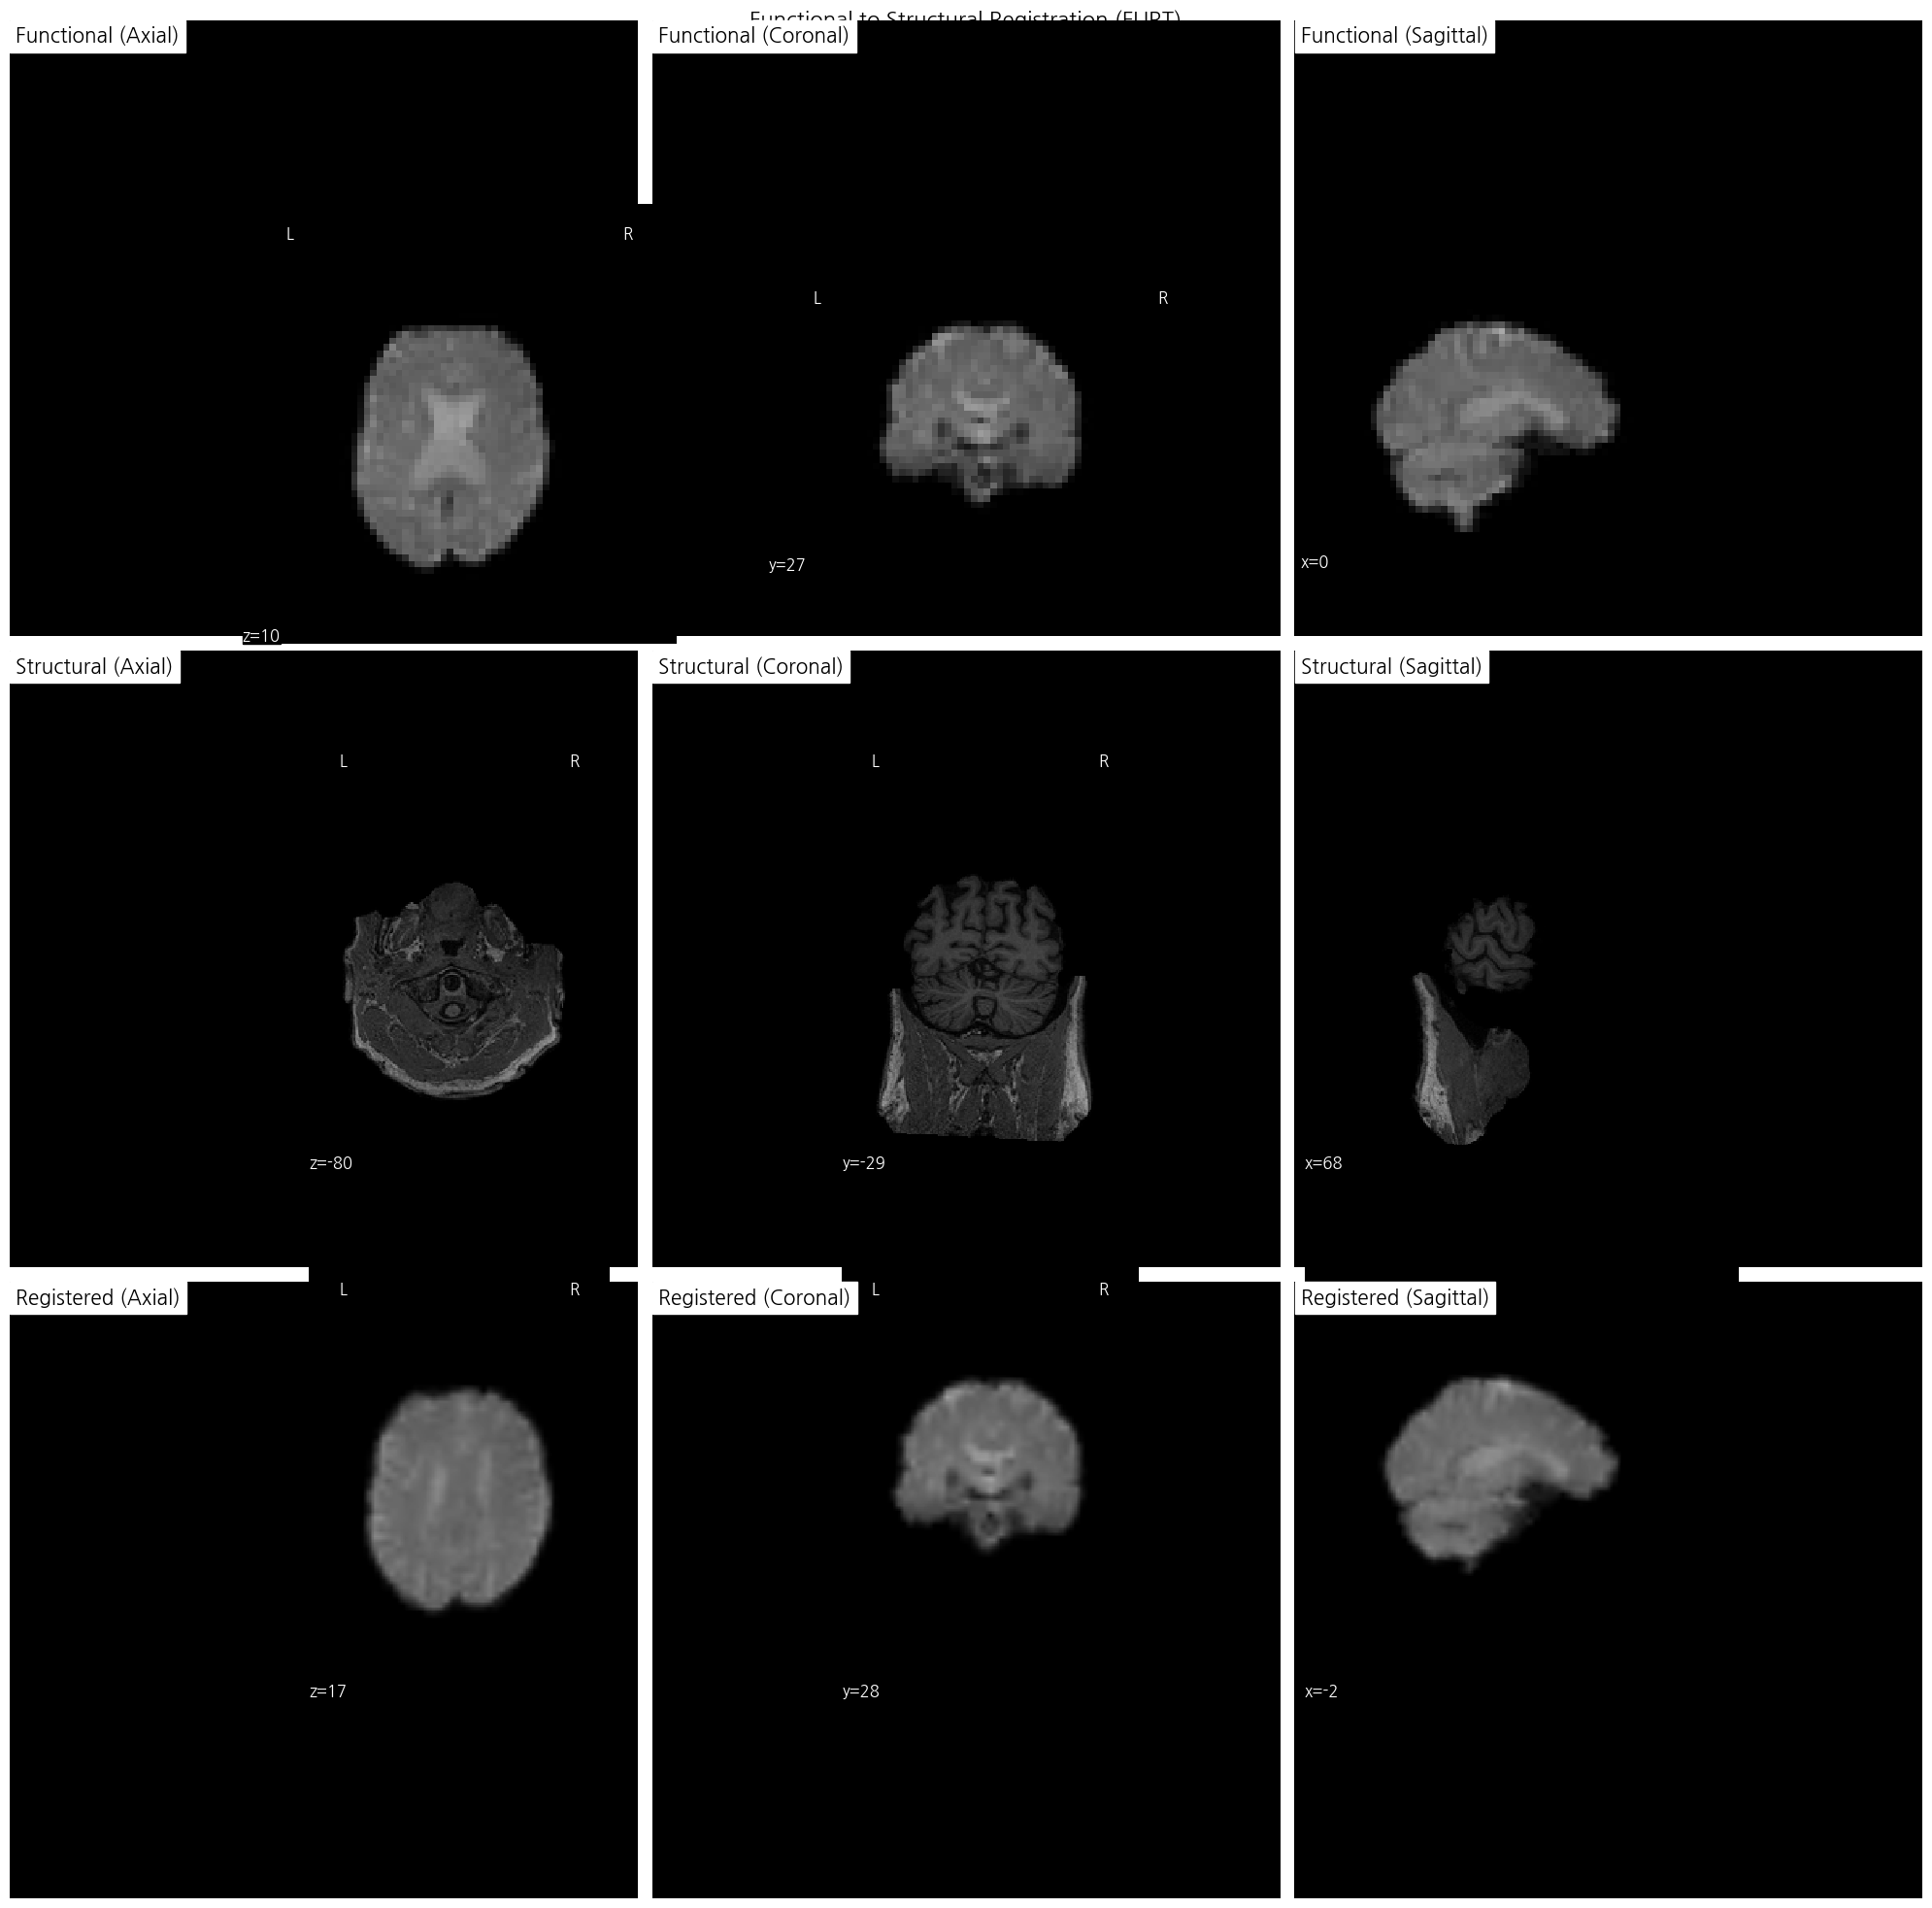

Experiments completed. Check the visualizations.


In [12]:
import os
import nibabel as nib
from nipype.interfaces import fsl
from nilearn import plotting
import matplotlib.pyplot as plt

def run_bet(in_file, out_file, frac=0.5):
    bet = fsl.BET(in_file=in_file, out_file=out_file, mask=True, frac=frac)
    result = bet.run()
    return result.outputs.out_file, result.outputs.mask_file

def run_flirt(in_file, ref_file, out_file, out_matrix_file, dof=6):
    flirt = fsl.FLIRT(in_file=in_file, reference=ref_file, out_file=out_file, 
                      out_matrix_file=out_matrix_file, dof=dof)
    result = flirt.run()
    return result.outputs.out_file, result.outputs.out_matrix_file

def visualize_registration(func_img, struct_img, registered_img, title):
    fig, axes = plt.subplots(3, 3, figsize=(20, 20))
    fig.suptitle(title, fontsize=16)
    
    for i, (img, subtitle) in enumerate(zip([func_img, struct_img, registered_img], 
                                            ['Functional', 'Structural', 'Registered'])):
        plotting.plot_anat(img, display_mode='z', cut_coords=1, title=f"{subtitle} (Axial)",
                           axes=axes[i, 0], draw_cross=False, cmap='gray')
        plotting.plot_anat(img, display_mode='y', cut_coords=1, title=f"{subtitle} (Coronal)",
                           axes=axes[i, 1], draw_cross=False, cmap='gray')
        plotting.plot_anat(img, display_mode='x', cut_coords=1, title=f"{subtitle} (Sagittal)",
                           axes=axes[i, 2], draw_cross=False, cmap='gray')
    
    plt.tight_layout()
    plt.show()

def experiment_func_to_struct_registration(func_file, struct_file, work_dir, method='flirt'):
    # Extract first volume of fMRI
    func_img = nib.load(func_file)
    first_volume = nib.Nifti1Image(func_img.get_fdata()[:,:,:,0], func_img.affine)
    first_volume_file = os.path.join(work_dir, "first_volume.nii.gz")
    nib.save(first_volume, first_volume_file)
    
    # Run BET on functional image
    bet_file, bet_mask_file = run_bet(first_volume_file, os.path.join(work_dir, "func_brain.nii.gz"))
    
    # Run BET on structural image
    struct_brain_file, _ = run_bet(struct_file, os.path.join(work_dir, "struct_brain.nii.gz"))
    
    # Perform registration
    if method == 'flirt':
        registered_file, _ = run_flirt(bet_file, struct_brain_file, 
                                       os.path.join(work_dir, "func_to_struct_flirt.nii.gz"),
                                       os.path.join(work_dir, "func_to_struct_flirt.mat"))

    else:
        raise ValueError("Method must be either 'flirt' or 'fnirt'")
    
    # Visualize results
    visualize_registration(bet_file, struct_brain_file, registered_file, 
                           f"Functional to Structural Registration ({method.upper()})")
    
    return registered_file

# 사용 예:
base_dir = "/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1"
subject_dir = "OAS30011_MR_d0055"
subject_id = "OAS30011"
session_id = "d0055"

func_file = os.path.join(base_dir, subject_dir, "func2", "NIFTI", f"sub-{subject_id}_ses-{session_id}_task-rest_run-02_bold.nii.gz")
struct_file = os.path.join(base_dir, subject_dir, "anat2", "NIFTI", f"sub-{subject_id}_ses-{session_id}_T1w.nii.gz")
work_dir = os.path.join(base_dir, subject_dir, "fMRI_preprocessing")
os.makedirs(work_dir, exist_ok=True)

# FLIRT를 사용한 실험
flirt_result = experiment_func_to_struct_registration(func_file, struct_file, work_dir, method='flirt')

print("Experiments completed. Check the visualizations.")

/tmp/ipykernel_380320/3978634264.py:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


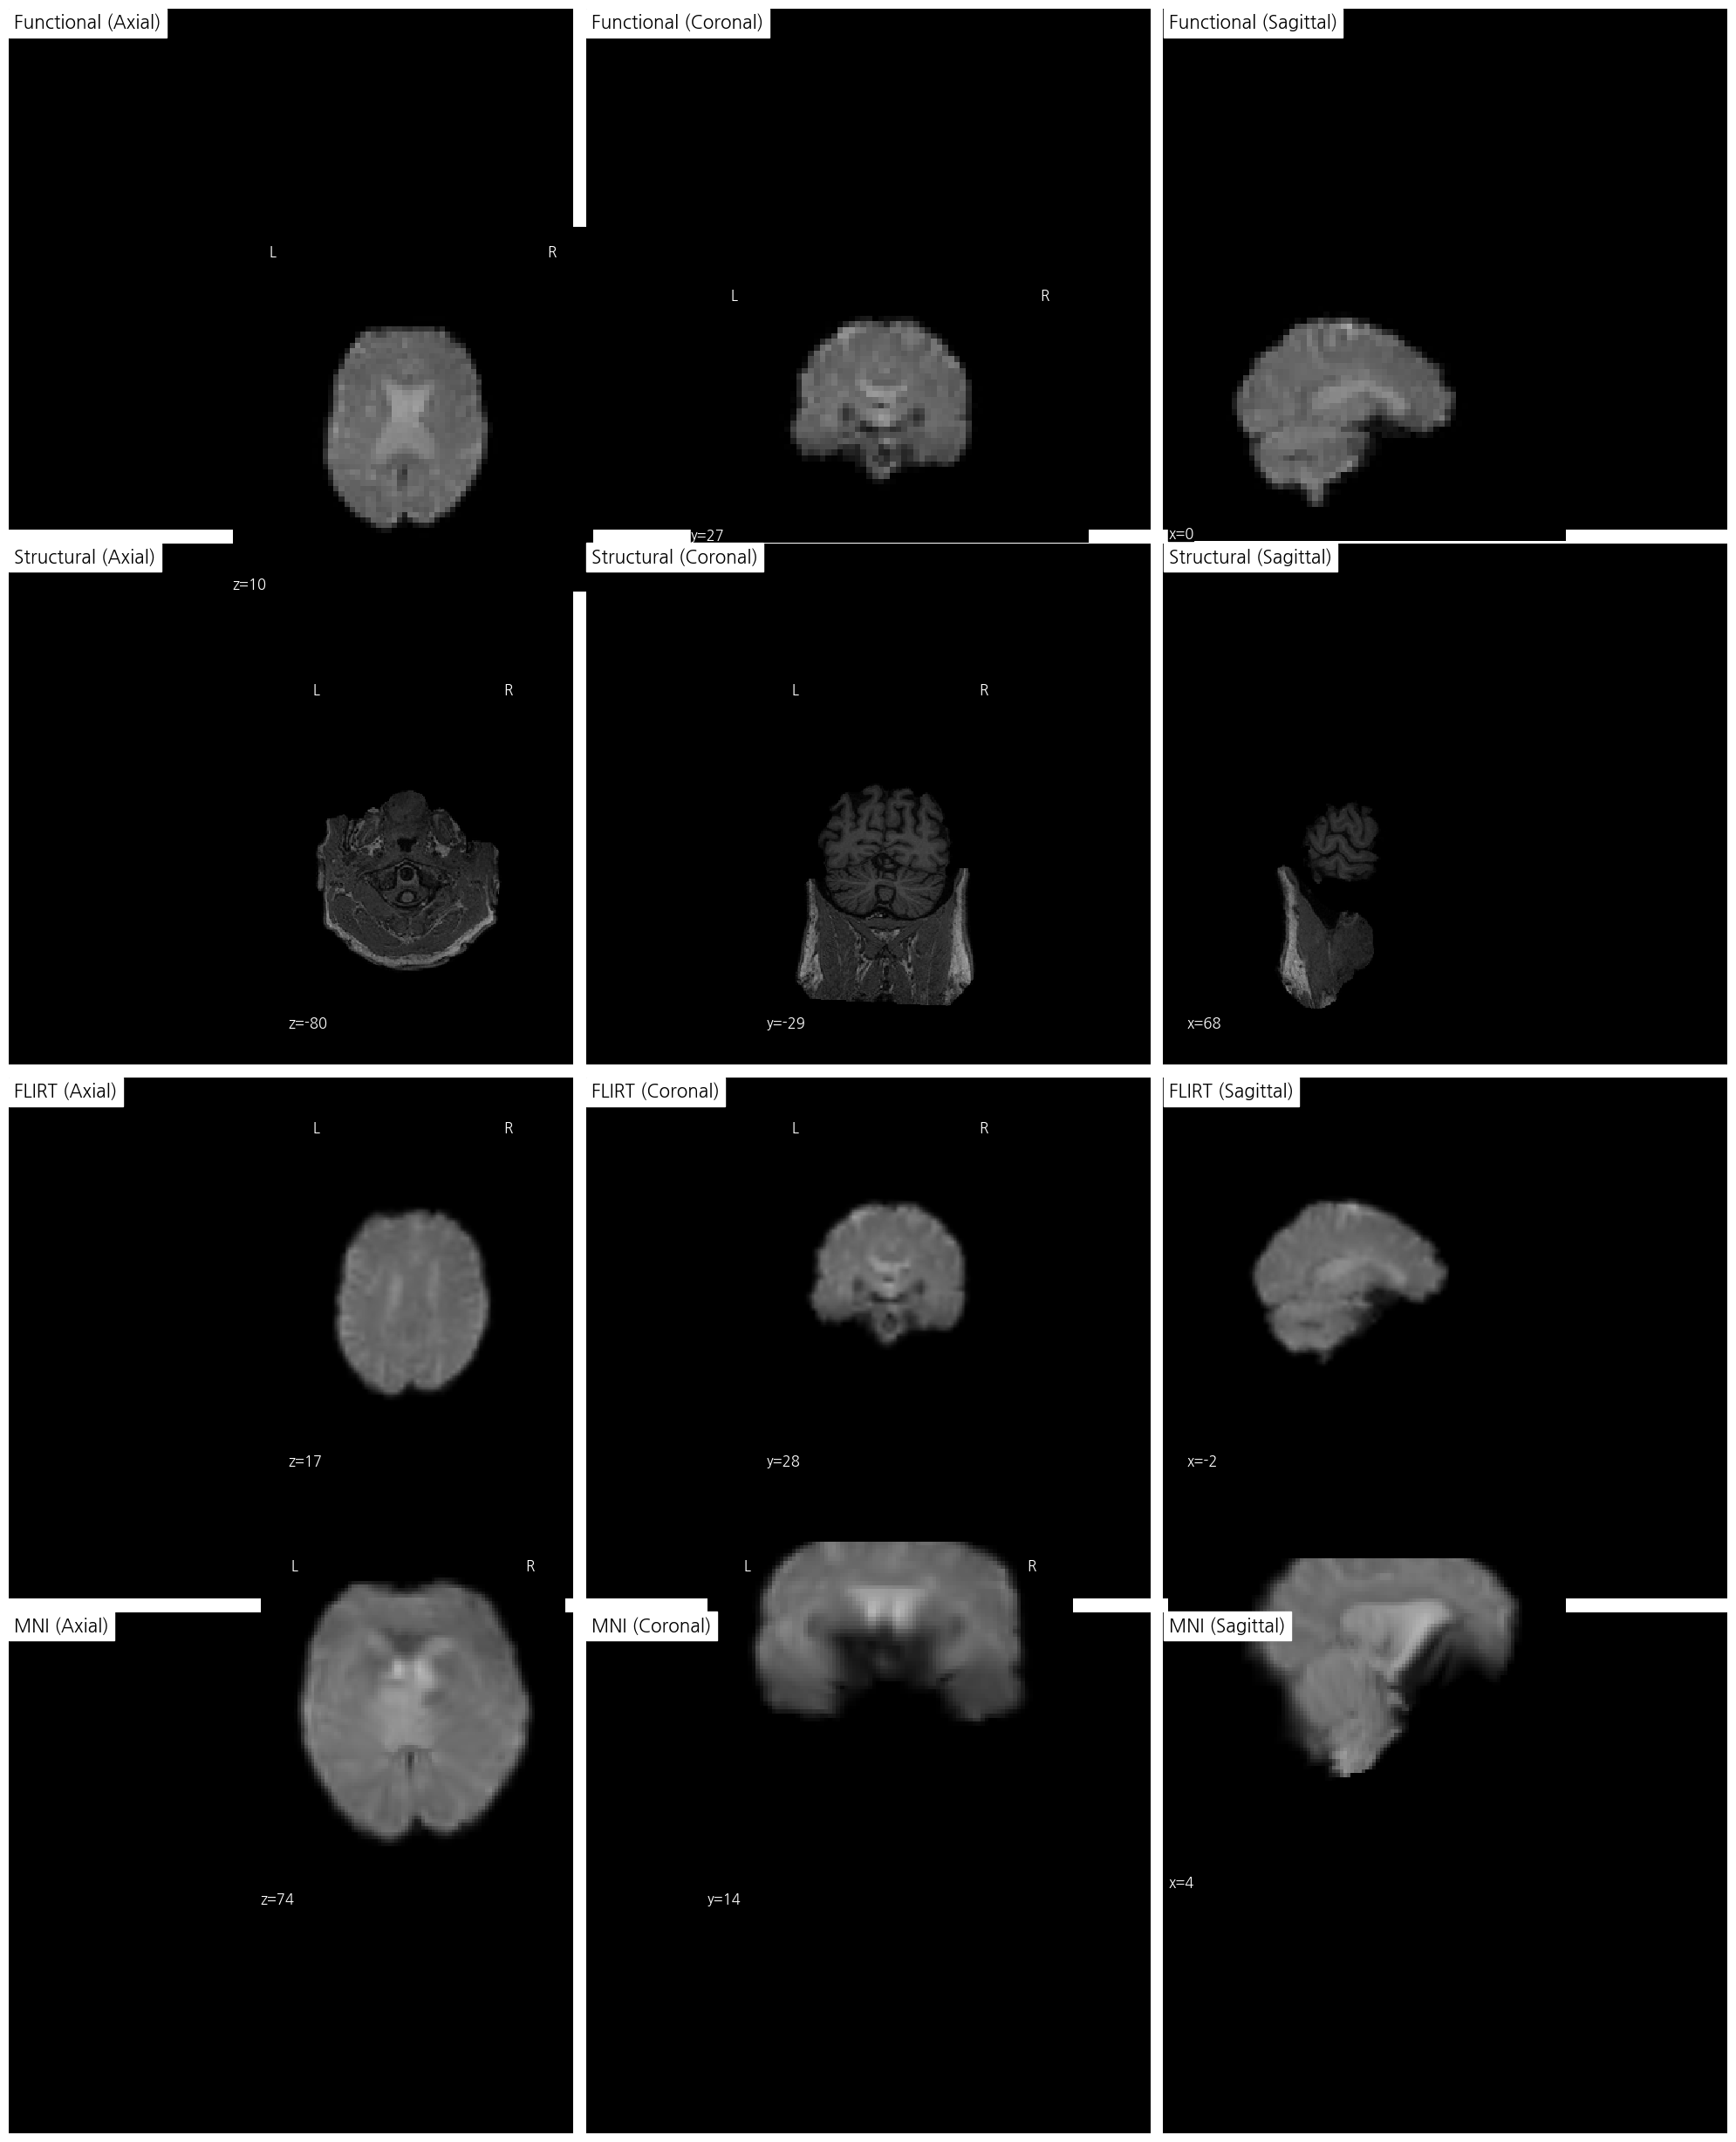

Experiment completed. Check the visualizations.


In [13]:
import os
import nibabel as nib
from nipype.interfaces import fsl
from nilearn import plotting
import matplotlib.pyplot as plt

def run_bet(in_file, out_file, frac=0.5):
    bet = fsl.BET(in_file=in_file, out_file=out_file, mask=True, frac=frac)
    result = bet.run()
    return result.outputs.out_file, result.outputs.mask_file

def run_flirt(in_file, ref_file, out_file, out_matrix_file, dof=6):
    flirt = fsl.FLIRT(in_file=in_file, reference=ref_file, out_file=out_file, 
                      out_matrix_file=out_matrix_file, dof=dof)
    result = flirt.run()
    return result.outputs.out_file, result.outputs.out_matrix_file

def run_fnirt(in_file, ref_file, out_file, out_warp_file):
    fnirt = fsl.FNIRT(in_file=in_file, ref_file=ref_file, warped_file=out_file,
                      fieldcoeff_file=out_warp_file, config_file='T1_2_MNI152_2mm')
    result = fnirt.run()
    return result.outputs.warped_file, result.outputs.fieldcoeff_file

def visualize_registration(func_img, struct_img, flirt_img, mni_img, title):
    fig, axes = plt.subplots(4, 3, figsize=(20, 25))
    fig.suptitle(title, fontsize=16)
    
    for i, (img, subtitle) in enumerate(zip([func_img, struct_img, flirt_img, mni_img], 
                                            ['Functional', 'Structural', 'FLIRT', 'MNI'])):
        plotting.plot_anat(img, display_mode='z', cut_coords=1, title=f"{subtitle} (Axial)",
                           axes=axes[i, 0], draw_cross=False, cmap='gray')
        plotting.plot_anat(img, display_mode='y', cut_coords=1, title=f"{subtitle} (Coronal)",
                           axes=axes[i, 1], draw_cross=False, cmap='gray')
        plotting.plot_anat(img, display_mode='x', cut_coords=1, title=f"{subtitle} (Sagittal)",
                           axes=axes[i, 2], draw_cross=False, cmap='gray')
    
    plt.tight_layout()
    plt.show()

def experiment_func_to_struct_to_mni_registration(func_file, struct_file, mni_template, work_dir):
    # Extract first volume of fMRI
    func_img = nib.load(func_file)
    first_volume = nib.Nifti1Image(func_img.get_fdata()[:,:,:,0], func_img.affine)
    first_volume_file = os.path.join(work_dir, "first_volume.nii.gz")
    nib.save(first_volume, first_volume_file)
    
    # Run BET on functional image
    bet_file, bet_mask_file = run_bet(first_volume_file, os.path.join(work_dir, "func_brain.nii.gz"))
    
    # Run BET on structural image
    struct_brain_file, _ = run_bet(struct_file, os.path.join(work_dir, "struct_brain.nii.gz"))
    
    # Perform FLIRT registration
    flirt_file, flirt_matrix = run_flirt(bet_file, struct_brain_file, 
                                         os.path.join(work_dir, "func_to_struct_flirt.nii.gz"),
                                         os.path.join(work_dir, "func_to_struct_flirt.mat"))
    
    # Perform FNIRT registration to MNI space
    mni_file, warp_file = run_fnirt(struct_brain_file, mni_template,
                                    os.path.join(work_dir, "struct_to_mni_fnirt.nii.gz"),
                                    os.path.join(work_dir, "struct_to_mni_warp.nii.gz"))
    
    # Apply FNIRT warp to FLIRT result
    func_to_mni_file = os.path.join(work_dir, "func_to_mni_fnirt.nii.gz")
    apply_warp = fsl.ApplyWarp(in_file=flirt_file, ref_file=mni_template, 
                               field_file=warp_file, out_file=func_to_mni_file)
    apply_warp.run()
    
    # Visualize results
    visualize_registration(bet_file, struct_brain_file, flirt_file, func_to_mni_file, 
                           "Functional to Structural to MNI Registration")
    
    return func_to_mni_file

# 사용 예:
base_dir = "/home/minyoungxi/MINYOUNGXI/XFL/Data/OASISSamples7.1"
subject_dir = "OAS30011_MR_d0055"
subject_id = "OAS30011"
session_id = "d0055"

func_file = os.path.join(base_dir, subject_dir, "func2", "NIFTI", f"sub-{subject_id}_ses-{session_id}_task-rest_run-02_bold.nii.gz")
struct_file = os.path.join(base_dir, subject_dir, "anat2", "NIFTI", f"sub-{subject_id}_ses-{session_id}_T1w.nii.gz")
mni_template = os.path.join(os.environ['FSLDIR'], 'data', 'standard', 'MNI152_T1_2mm_brain.nii.gz')
work_dir = os.path.join(base_dir, subject_dir, "fMRI_preprocessing")
os.makedirs(work_dir, exist_ok=True)

# FLIRT와 FNIRT를 사용한 실험
result = experiment_func_to_struct_to_mni_registration(func_file, struct_file, mni_template, work_dir)

print("Experiment completed. Check the visualizations.")